# 勾配ブースティング決定木 (GBDT) のスクラッチ実装 (NumPy)

このノートブックでは、Jerome H. Friedman氏の論文「Greedy Function Approximation: A Gradient Boosting Machine」のアイデアに基づき、NumPyとPython標準ライブラリのみを使用して勾配ブースティング決定木（GBDT）をスクラッチから実装します。

まずは回帰タスクに焦点を当て、損失関数として二乗誤差を使用します。

**主なステップ:**
1. 必要なライブラリと以前に作成した決定木クラスのインポート
2. データセットの準備 (回帰用)
3. GBDTのアルゴリズム概要 (回帰の場合)
4. GradientBoostingRegressorクラスの実装
    - 初期モデルの決定
    - 損失関数の勾配（残差）の計算
    - 各イテレーションでの決定木（リグレッサー）の学習
    - 予測
5. モデルの学習と評価 (サンプルデータとBoston Housingデータセット)

## 1. ライブラリのインポート

In [1]:
import numpy as np
import random
import time
import sys, os

# 作成した決定木クラス
sys.path.append(os.path.abspath('../src/Tree'))
from DecisionTree import DecisionTreeRegression, Node, print_tree

## 2. データセットの準備 (回帰用)

ここでは、まず簡単な回帰用のサンプルデータを作成し、その後、より一般的なBoston Housingデータセットでテストします。

### 2.1 サンプルデータ (回帰用)

サンプルデータ X_sample_reg (shape): (80, 1)
サンプルラベル y_sample_reg (shape): (80,)


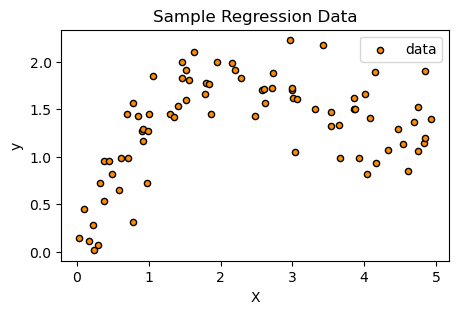

In [ ]:
# サンプルデータ (回帰)
# X は (サンプル数, 特徴量数) の形状
np.random.seed(42) # 再現性のため
X_sample_reg = np.sort(5 * np.random.rand(80, 1), axis=0)
# y は y = sin(X) + X/2 + noise のような非線形な関係を想定
y_sample_reg = np.sin(X_sample_reg).ravel() + X_sample_reg.ravel() * 0.5 + np.random.randn(80) * 0.3

# GBDTは複数の特徴量を扱えるが、可視化のために1特徴量で開始
# 後で多次元特徴量でテストする
feature_types_sample_reg = ['numeric'] 

print("サンプルデータ X_sample_reg (shape):", X_sample_reg.shape)
print("サンプルラベル y_sample_reg (shape):", y_sample_reg.shape)

# 簡単なプロット
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
plt.scatter(X_sample_reg, y_sample_reg, s=20, edgecolor="black", c="darkorange", label="data")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Sample Regression Data")
plt.legend()
plt.show()

## 3. GBDTのアルゴリズム概要 (回帰の場合 - 二乗誤差損失)

Friedman (2001) の論文で説明されている勾配ブースティングの一般的な枠組みは以下の通りです。
ここでは、特に損失関数 $L(y, F)$ として二乗誤差 $L(y, F) = \frac{1}{2}(y - F)^2$ を考えます。

1.  **初期モデル $F_0(x)$ の決定:**
    損失関数を最小化する定数値で初期化します。二乗誤差の場合、これは訓練データ $y$ の平均値です。
    $F_0(x) = \text{argmin}_{\gamma} \sum_{i=1}^{N} L(y_i, \gamma) = \text{mean}(y)$

2.  **M個の決定木（弱学習器）を逐次的に構築する (m = 1 to M):**  
    各イテレーション $m$ で：  
    a.  **負の勾配（pseudo-residuals）の計算:**  
        現在のモデル $F_{m-1}(x)$ における損失関数の負の勾配を各サンプル $i$ について計算します。
        $r_{im} = - \left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x)=F_{m-1}(x)}$
        二乗誤差 $L(y, F) = \frac{1}{2}(y - F)^2$ の場合、$\frac{\partial L}{\partial F} = -(y - F)$ なので、負の勾配は $r_{im} = y_i - F_{m-1}(x_i)$ となり、これは現在の残差そのものです。

    b.  **弱学習器（決定木）の学習:**  
        計算された負の勾配（残差 $r_{im}$）をターゲットとして、新しい回帰用決定木 $h_m(x)$ を学習させます。
        $h_m(x)$ は入力 $X$ を用いて $r_{im}$ を予測するように学習されます。
        この決定木は通常、深さが浅いものが使われます (例: `max_depth` が小さい)。

    c.  **モデルの更新:**  
        固定の学習率 (learning rate, $\nu$) を用いて、各木の寄与を調整します。
        $F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)$

3.  **最終モデルの構築:**
    最終的な予測モデル $F_M(x)$ は、初期モデルと全ての弱学習器の（学習率で重み付けされた）和として得られます。
    $F_M(x) = F_0(x) + \sum_{m=1}^{M} \nu \cdot h_m(x)$

**GBDT (二乗誤差損失) の主なアイデア:**
*   各ステップで、モデルがまだ上手く説明できていない部分（残差）を学習する新しい木を追加していく。
*   学習率 $\nu$ を導入することで、個々の木の寄与を小さくし、過学習を抑制し、より多くの木をアンサンブルに含めることができる。

## 4. GradientBoostingRegressorクラスの実装

### 4.1 概念説明

*   **`__init__` メソッド**:
    *   GBDTのハイパーパラメータ（木の数 `n_estimators`、学習率 `learning_rate`、各木の深さ `max_depth` など）を初期化します。
    *   学習済みの初期モデル `self.initial_prediction_` と、各イテレーションで学習された決定木を格納するリスト `self.trees_` を準備します。

*   **`fit` メソッド**:
    *   **目的**: 訓練データ `X_train` と `y_train` を用いて、GBDTモデルを学習させます。
    *   **処理の流れ**:
        1.  **初期予測の計算**: `y_train` の平均値を `self.initial_prediction_` とし、現在の予測 `current_predictions` をこれで初期化します。
        2.  指定された `self.n_estimators` の数だけ以下のループを実行します:  
            a.  **残差の計算**: `residuals = y_train - current_predictions`。これが次の木が学習するターゲットとなります。  
            b.  **回帰用決定木の学習**: `DecisionTreeRegression` クラスのインスタンスを作成し、入力 `X_train` とターゲット `residuals` で学習させます。この際、`max_depth` などのパラメータを渡します。  
            c.  学習済みの木を `self.trees_` リストに追加します。  
            d.  **現在の予測の更新**: `current_predictions += self.learning_rate * new_tree.predict_single_tree(X_train)`。  

*   **`predict` メソッド**:
    *   **目的**: 学習済みのGBDTモデルを使って、新しい特徴量データ `X_test` に対する目的変数の値を予測します。
    *   **処理の流れ**:
        1.  予測値を初期モデル `self.initial_prediction_` (テストデータのサンプル数に合わせてブロードキャスト) で初期化します。
        2.  `self.trees_` リスト内の各決定木に対してループを実行し、各木の予測値に学習率 `self.learning_rate` を掛けたものを、現在の予測値に加算していきます。
        3.  最終的に得られた予測値を返します。

### 4.2 `GradientBoostingRegressor` クラスの実装

In [5]:
class GradientBoostingRegressor:
    def __init__(self,
                 n_estimators=100,
                 learning_rate=0.1,
                 max_depth=3,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 max_features=None,
                 random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        
        self.initial_prediction_ = None
        self.trees_ = []
        self.feature_types = None

    def fit(self, X_train, y_train, feature_type_list):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        self.trees_ = []
        self.feature_types = feature_type_list

        # 初期モデルF0(X)の決定
        self.initial_prediction_ = np.mean(y_train)
        current_predictions = np.full(shape=y_train.shape, fill_value=self.initial_prediction_)
        
        print(f"Fitting {self.n_estimators} trees with learning rate {self.learning_rate}...")

        for i in range(self.n_estimators):
            # 残差の計算
            residuals = y_train - current_predictions

            # 残差をターゲットとして回帰用の決定木をを学習
            tree = DecisionTreeRegression(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
            )

            tree.fit(X_train, residuals, self.feature_types)
            self.trees_.append(tree)

            # モデルの更新
            predictions_from_new_tree = tree.predict_single_tree(X_train)
            current_predictions += self.learning_rate * predictions_from_new_tree

            # 進捗の表示
            progress_interval = self.n_estimators // 10 if self.n_estimators >= 10 else 1
            if (i + 1) % progress_interval == 0 or i == self.n_estimators - 1:
                print(f"Tree {i + 1}/{self.n_estimators} fitted. Current predictions updated.")
        print("Fitting completed.")

    def predict(self, X_test):
        if self.initial_prediction_ is None:
            raise ValueError("Model has not been fitted yet. Call 'fit' before 'predict'.")
        
        # 初期予測値を設定
        current_predictions = np.full(shape=X_test.shape[0], fill_value=self.initial_prediction_)

        # 各決定木からの予測を加算
        for tree in self.trees_:
            current_predictions += self.learning_rate * tree.predict_single_tree(X_test)

        return current_predictions

## 5. モデルの学習と評価 (回帰)


### 5.1 サンプルデータでのテスト (回帰)

Fitting 100 trees with learning rate 0.1...
Tree 10/100 fitted. Current predictions updated.
Tree 20/100 fitted. Current predictions updated.
Tree 30/100 fitted. Current predictions updated.
Tree 40/100 fitted. Current predictions updated.
Tree 50/100 fitted. Current predictions updated.
Tree 60/100 fitted. Current predictions updated.
Tree 70/100 fitted. Current predictions updated.
Tree 80/100 fitted. Current predictions updated.
Tree 90/100 fitted. Current predictions updated.
Tree 100/100 fitted. Current predictions updated.
Fitting completed.

Sample Data (Regression) - GBDT MSE: 0.0670


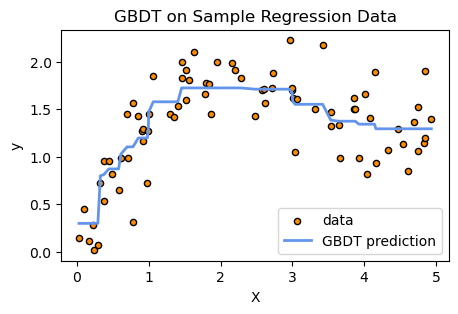

In [10]:
gbr_sample = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=2,
    min_samples_leaf=5,
    random_state=42
)

# 学習
gbr_sample.fit(X_sample_reg, y_sample_reg, feature_types_sample_reg)

# 予測
y_pred_sample_reg = gbr_sample.predict(X_sample_reg)

# 簡単な評価 (MSE)
mse_sample_reg = np.mean((y_sample_reg - y_pred_sample_reg)**2)
print(f"\nSample Data (Regression) - GBDT MSE: {mse_sample_reg:.4f}")

# プロットで確認
import matplotlib.pyplot as plt # このセルでインポート
plt.figure(figsize=(5, 3))
plt.scatter(X_sample_reg, y_sample_reg, s=20, edgecolor="black", c="darkorange", label="data")
# 予測はX_sample_regがソートされている前提でプロット
# X_sample_reg は既にソート済み
plt.plot(X_sample_reg, y_pred_sample_reg, color="cornflowerblue", label="GBDT prediction", linewidth=2)
plt.xlabel("X")
plt.ylabel("y")
plt.title("GBDT on Sample Regression Data")
plt.legend()
plt.show()

### 5.2 California Housingデータセットでのテスト (回帰)

より実践的な回帰データセットであるCalifornia Housingデータセットでテストします。
(以前のBoston Housingは倫理的問題で使用非推奨のため変更)

In [8]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# California Housingデータセットのロード
housing = fetch_california_housing()
X_housing = housing.data
y_housing = housing.target
housing_feature_names = housing.feature_names
feature_types_housing = ['numeric'] * X_housing.shape[1]

print("California Housing dataset loaded.")
print("Data shape X:", X_housing.shape)
print("Data shape y:", y_housing.shape)

# 特徴量の標準化
scaler = StandardScaler()
X_housing_scaled = scaler.fit_transform(X_housing)

# 訓練データとテストデータに分割
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_housing_scaled, y_housing, test_size=0.2, random_state=42
)

print("Housing Training data shape:", X_train_h.shape)
print("Housing Test data shape:", X_test_h.shape)

California Housing dataset loaded.
Data shape X: (20640, 8)
Data shape y: (20640,)
Housing Training data shape: (16512, 8)
Housing Test data shape: (4128, 8)


In [9]:
# Housingデータセット用GBDTモデル
gbr_housing = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_leaf=10,
    max_features='sqrt', # 特徴量のサブサンプリング
    random_state=42
)

print("\nStarting Housing GBDT training...")
start_time = time.time()

# 学習
gbr_housing.fit(X_train_h, y_train_h, feature_types_housing)

end_time = time.time()
training_time_h = end_time - start_time
print(f"Housing GBDT training finished in {training_time_h:.2f} seconds.")

# テストデータで予測
print("\nPredicting on Housing test data...")
y_pred_test_h = gbr_housing.predict(X_test_h)

# 評価
mse_housing_test = mean_squared_error(y_test_h, y_pred_test_h)
r2_housing_test = r2_score(y_test_h, y_pred_test_h)

print(f"\nHousing Test Data - GBDT MSE: {mse_housing_test:.4f}")
print(f"Housing Test Data - GBDT R²: {r2_housing_test:.4f}")

# (比較) 学習データでの性能
y_pred_train_h = gbr_housing.predict(X_train_h)
mse_housing_train = mean_squared_error(y_train_h, y_pred_train_h)
r2_housing_train = r2_score(y_train_h, y_pred_train_h)
print(f"\nHousing Training Data - GBDT MSE: {mse_housing_train:.4f}")
print(f"Housing Training Data - GBDT R²: {r2_housing_train:.4f}")


Starting Housing GBDT training...
Fitting 100 trees with learning rate 0.1...
Tree 10/100 fitted. Current predictions updated.
Tree 20/100 fitted. Current predictions updated.
Tree 30/100 fitted. Current predictions updated.
Tree 40/100 fitted. Current predictions updated.
Tree 50/100 fitted. Current predictions updated.
Tree 60/100 fitted. Current predictions updated.
Tree 70/100 fitted. Current predictions updated.
Tree 80/100 fitted. Current predictions updated.
Tree 90/100 fitted. Current predictions updated.
Tree 100/100 fitted. Current predictions updated.
Fitting completed.
Housing GBDT training finished in 633.39 seconds.

Predicting on Housing test data...

Housing Test Data - GBDT MSE: 0.3189
Housing Test Data - GBDT R²: 0.7566

Housing Training Data - GBDT MSE: 0.2916
Housing Training Data - GBDT R²: 0.7819


## 6. 考察 (論文との関連など)

*   **実装したアルゴリズム (回帰 - 二乗誤差損失)**:
    *   Friedmanの勾配ブースティングの枠組みに基づき、各イテレーションで現在のモデルの残差（二乗誤差損失の負の勾配）に対して**回帰用決定木 (`DecisionTreeRegression`)** を学習させました。
    *   学習率を導入し、各木の寄与を調整しています。
*   **論文 (Friedman, 2001) との関連**:
    *   今回の実装は、論文のAlgorithm 2 (LS_Boost) に非常に近いです。LS_Boostは二乗誤差損失に対する勾配ブースティングの手順そのものです。
        *   `F₀(x) = mean(y)` (初期化)
        *   各ステップ `m` で残差 `ỹᵢ = yᵢ - F_{m-1}(xᵢ)` を計算し、これに対して決定木 `h_m(x)` をフィットさせます。
        *   モデルを `F_m(x) = F_{m-1}(x) + ν * h_m(x)` のように更新します（`ν` は学習率）。
    *   論文では、より一般の損失関数に対する勾配ブースティング (Algorithm 1) や、LAD損失 (Algorithm 3)、Huber損失 (Algorithm 4)、分類用のLogLoss (Algorithm 5, 6) など、様々な損失関数への応用が詳細に議論されています。
    *   正規化 (Regularization) として、学習率 `ν` (shrinkage) と木の数 `M` (`n_estimators`) が重要です (Section 5)。また、木の深さ (`max_depth` などで制御される葉の数 `J`) も重要なハイパーパラメータです (Section 7)。
*   **改善点や今後の課題**:
    *   **損失関数の一般化**: 今回は二乗誤差損失に特化しましたが、他の微分可能な損失関数（LAD、Huber、分類用のLogLossなど）にも拡張可能です。そのためには、各損失関数に対応する負の勾配を計算し、それをターゲットとして決定木を学習させる必要があります。分類の場合は、確率予測とそれに対応する損失関数の勾配を扱うことになります。
    *   **ラインサーチ**: 学習率 `ν` を固定する代わりに、論文で提案されているように各ステップで最適なステップサイズ `ρ_m` をラインサーチで決定することで、より効率的な学習や性能向上が期待できる場合があります（実装は複雑になります）。特に、各木の葉ノードの値を、その葉ノードに含まれるサンプルの勾配に基づいて最適化する方法が一般的です。
    *   **早期停止 (Early Stopping)**: 検証セットを用意し、検証セットの誤差が悪化し始めたら学習を停止する早期停止を導入することで、最適な `n_estimators` を見つけることができます。
    *   **サブサンプリング (Stochastic Gradient Boosting)**: 各木を学習する際に、訓練データの一部をランダムに（非復元）サンプリングして使用する手法です。これにより、計算コストを削減し、バリアンスを減らして過学習を抑制する効果が期待できます。
    *   **分類タスクへの対応**: 分類タスク（例：二値分類、多クラス分類）に対応するには、適切な損失関数（例：LogLoss、指数損失）とその勾配を定義し、確率を出力するようにモデルを修正する必要があります。多クラス分類では、クラスごとにモデル（または木のセット）を構築することが一般的です。